# **Install and Load Libraries needed for the task**

In [ ]:
!pip install utils

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import zipfile
import os
import gensim
import utils
import json
import random
import pickle
from operator import itemgetter
from copy import deepcopy
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

# **Loading Data**

In [ ]:
# Download the dataset
url = "https://nlp.stanford.edu/sentiment/trainDevTestTrees_PTB.zip"
try:
    local_filename, headers = urllib.request.urlretrieve(url, "trainDevTestTrees_PTB.zip")
except Exception as e:
    print(e)
print(local_filename)

trainDevTestTrees_PTB.zip


In [ ]:
# Extract the dataset
with zipfile.ZipFile(local_filename, 'r') as my_zip:
    my_zip.extractall("trainDevTestTrees_PTB")
os.listdir("trainDevTestTrees_PTB") # List down the extracted data files

['trees']

In [ ]:
# Load Data

def load_sentences(path):
    """
    Output would be
    sentences = a nData x k array of sentences, where k = number of WORDS in each sentence. Each row is a sentence split
    into strings of WORDS
    labels = a nData array of ratings (integer) for each sentence
    """
    sentences = []
    labels = []
    file = open(path, "r")
    for line in file:
        soup = line.split() # first split each line (of whole sentence rating along with (rating WORD) pairs) into mini-strings seperated by space. Since there's always a space between a rating and a rated WORD, the ratings would be seperated from the WORD as 2 strings
        labels.append(int(soup[0].lstrip("("))) # the first number from the left is the rating of the sentence. Take out the leading brackets in the first string, and convert that number char to integer
        tokens = []
        for chunk in soup[1:]:
            if chunk.endswith(")"): # every string chunks with a WORD, ends with a ')' because the original format was (rating word). Rating and word seperated due to space between as before
                tokens.append(chunk.rstrip(")")) # hence remove the rightmost ')' and append to the 'tokens' array. This is just array of words
        sentences.append(tokens) # at the end, append this array. This would be a sentence, divided into strings of words
    return sentences, labels

def get_everything_in_one_char_str(str_set,chars_needed): # unused?
    final_str = ""
    for i in range(len(str_set)):
        final_str += " " + " ".join(str_set[i]) # join all words in str_set[i] (i.e. a sentence which is array of word strings) seperating each word with a space.
        # then join all these sentences also into a single long string.
    final_str = final_str.lstrip() # Remove the leftmost space
    final_str = ''.join([char for char in final_str if char in chars_needed]) # remove unwanted chars. Here, re-join each wanted character in the long string (of ALL sentences) without seperation (since we already contain spaces in this long string)
    return final_str

def erase_invalid_simbols(sentences,chars_needed):
    """
    To erase invalid symbols from every word in the extracted sentences. Invalid means not alphabets and symbols declared below
    Output:
    A 2D array of size nData x k where k = length of each sentences.
    """
    new_sentences=[]
    for sentence in sentences:
        token=[] # array to store the 'filtered' word
        for word in sentence:
            word_new=''
            for char in word:
                if char in chars_needed:
                    word_new+=char # filter a word to contain only wanted characters
            if not(word_new == ''):
                token.append(word_new)
        new_sentences.append(token)
    return new_sentences
                    
        
        
        

chars_needed = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J','K', 'L', 'M', 'N', 'O', 'P','Q','R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

In [ ]:
# Self-picked sentences for the last part of this task
sentences_addtest = ["A bitter disappointment and awful ending to a brilliant trilogy .", "The Dark Knight Rises was a perfect sequel to a masterpiece .", "Christopher Nolan's second bundle of joy The Dark Knight exceeded all of my expectations !!!",
                     "A lame spy spoof with no real laughs or surprises", "Not The Worst Brit Comedy You Will See"]
labels_add_test = [0, 4, 4, 0, 1]
sentences_add_test = []
for sentence in sentences_addtest:
    sentences_add_test.append(sentence.split())

print(sentences_add_test)
print(len(sentences_add_test))

[['A', 'bitter', 'disappointment', 'and', 'awful', 'ending', 'to', 'a', 'brilliant', 'trilogy', '.'], ['The', 'Dark', 'Knight', 'Rises', 'was', 'a', 'perfect', 'sequel', 'to', 'a', 'masterpiece', '.'], ['Christopher', "Nolan's", 'second', 'bundle', 'of', 'joy', 'The', 'Dark', 'Knight', 'exceeded', 'all', 'of', 'my', 'expectations', '!!!'], ['A', 'lame', 'spy', 'spoof', 'with', 'no', 'real', 'laughs', 'or', 'surprises'], ['Not', 'The', 'Worst', 'Brit', 'Comedy', 'You', 'Will', 'See']]
5


In [ ]:
# Extract sentences and its label
sentences_train, labels_train = load_sentences("trainDevTestTrees_PTB/trees/train.txt")
sentences_val, labels_val = load_sentences("trainDevTestTrees_PTB/trees/dev.txt")
sentences_test, labels_test = load_sentences("trainDevTestTrees_PTB/trees/test.txt")


labels_train= np.asarray(labels_train)
print(labels_train.shape)
labels_val= np.asarray(labels_val)
print(labels_val.shape)
labels_test= np.asarray(labels_test)
print(labels_test.shape)
print(max(labels_train))

(8544,)
(1101,)
(2210,)
4


In [ ]:
# To check that we didn't remove any sentences
print(len(sentences_train), len(sentences_val), len(sentences_test))

8544 1101 2210


In [ ]:
# Remove invalid symbols in all sentences. We only take alphabets
sentences_train=erase_invalid_simbols(sentences_train,chars_needed)
sentences_val=erase_invalid_simbols(sentences_val,chars_needed)
sentences_test=erase_invalid_simbols(sentences_test,chars_needed)
sentences_add_test = erase_invalid_simbols(sentences_add_test, chars_needed)

print(len(sentences_train), len(sentences_val), len(sentences_test), len(sentences_add_test))

# As seen here, we did not remove any sentences by removing the 'invalid' characters

8544 1101 2210 5


In [ ]:
# Check if the additional sentences are loaded correctly
sentences_add_test

[['A',
  'bitter',
  'disappointment',
  'and',
  'awful',
  'ending',
  'to',
  'a',
  'brilliant',
  'trilogy'],
 ['The',
  'Dark',
  'Knight',
  'Rises',
  'was',
  'a',
  'perfect',
  'sequel',
  'to',
  'a',
  'masterpiece'],
 ['Christopher',
  'Nolans',
  'second',
  'bundle',
  'of',
  'joy',
  'The',
  'Dark',
  'Knight',
  'exceeded',
  'all',
  'of',
  'my',
  'expectations'],
 ['A',
  'lame',
  'spy',
  'spoof',
  'with',
  'no',
  'real',
  'laughs',
  'or',
  'surprises'],
 ['Not', 'The', 'Worst', 'Brit', 'Comedy', 'You', 'Will', 'See']]

In [ ]:
# Check also if sentences in the given dataset are loaded correctly
sentences_val[0]

['It',
 's',
 'a',
 'lovely',
 'film',
 'with',
 'lovely',
 'performances',
 'by',
 'Buy',
 'and',
 'Accorsi']

# **Load the pre-trained word2vec from google**

In [ ]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2020-12-11 16:17:09--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.66.14
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.66.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘/root/input/GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  77.9MB/s    in 20s     

2020-12-11 16:17:29 (79.3 MB/s) - ‘/root/input/GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
# Load Google's pre-trained Word2Vec model.
w2v = gensim.models.KeyedVectors.load_word2vec_format('/root/input/GoogleNews-vectors-negative300.bin.gz', binary=True)  
# model is a dictionary

In [ ]:
# Check similarity
w2v.n_similarity('the', 'The')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.87517774

In [ ]:
# Create dict to convert words (and therefore sentences) to integers and list of integers
w2v_dict = {token: index for (index,token) in enumerate(w2v.vocab)}

In [ ]:
# as follows
w2v_dict['UNK']

98307

In [ ]:
# Coding every word into 300 dimensional vector
vector = w2v['me']
print(vector.shape)

(300,)


## **Preprocessing of data**

In [ ]:
# Checking for unknown words which have no embedding
def put_unk(sentences, w2v_dict): #should we erase them?
    """
    Returns the sentences as before, but now replacing words without embedding as unknowns
    Also returns a list of words that have no embeddings (which we replace in our corpus)
    """
    unknown=[]
    new_sentences=[]
    for sentence in sentences:
        token=[]
        for word in sentence:
            if not (word in w2v_dict):
                token.append('UNK')
                if not(word in unknown):
                    unknown.append(word)  
            else:
                token.append(word)
        
        new_sentences.append(token)     
    return  new_sentences, unknown

# Sentences to embeddings
def embed(sentences,w2v_dict):
    new_sentences=[]
    for sentence in sentences:
        token=[] # embedding for a sentence, would be sentence_length x 300
        for word in sentence:
            token.append(w2v_dict[word].reshape(1,-1)) # embed every word in the sentence to a 300 x 1 vector
        token_np = np.concatenate(token, axis=0) # convert the sentence embedding to an np array
        new_sentences.append(token_np) # embedding for all sentences in the corpus, would be a list of length nData. Each element would be the sentence embedding
    return  new_sentences



In [ ]:
# Checking for unknow words which have no embedding, and putting UNK istead of that word
sentences_train, unkt = put_unk(sentences_train,w2v)
sentences_val, unkv = put_unk(sentences_val,w2v)
sentences_test, unkte = put_unk(sentences_test,w2v)
sentences_add_test, unkadte = put_unk(sentences_add_test, w2v)

In [ ]:
# Check if words in the additional sentences are marked correctly as unknowns
sentences_add_test

[['A',
  'bitter',
  'disappointment',
  'UNK',
  'awful',
  'ending',
  'UNK',
  'UNK',
  'brilliant',
  'trilogy'],
 ['The',
  'Dark',
  'Knight',
  'Rises',
  'was',
  'UNK',
  'perfect',
  'sequel',
  'UNK',
  'UNK',
  'masterpiece'],
 ['Christopher',
  'Nolans',
  'second',
  'bundle',
  'UNK',
  'joy',
  'The',
  'Dark',
  'Knight',
  'exceeded',
  'all',
  'UNK',
  'my',
  'expectations'],
 ['A',
  'lame',
  'spy',
  'spoof',
  'with',
  'no',
  'real',
  'laughs',
  'or',
  'surprises'],
 ['Not', 'The', 'Worst', 'Brit', 'Comedy', 'You', 'Will', 'See']]

In [ ]:
# Remove all but 1 unknowns in sentences
def remove_all_but_one_unk(sentences,labels):
    # Input is an array of sentences
    sentences2 = deepcopy(sentences)
    for j in range(len(sentences)):
        unk_count = 0
        for i in range(len(sentences[j])):
            word = sentences[j][i]
            if word == 'UNK':
                unk_count += 1
                if unk_count >= 2 and len(sentences2[j]) > 1:
                    sentences2[j].remove('UNK')
    
    return sentences2, labels # not removing sentences, so labels should still correspond

# Remove stopwords as defined below
def remove_stopwords(sentences, words_to_remove):
    sentences2 = deepcopy(sentences)
    for i in range(len(sentences)):
        for word in sentences[i]:
            if word in words_to_remove and len(sentences2[i]) > 1:
                sentences2[i].remove(word)
                
    return sentences2

# Removing words that only have one letters
def remove_one_letter_words(sentences,labels):
    sentences2 = deepcopy(sentences)
    for i in range(len(sentences)):
        for word in sentences[i]:
            if len(word)==1 and len(sentences2[i]) > 1:
                sentences2[i].remove(word)
                
    return sentences2, labels # Again, not removing any sentences, so labels should still correspond

def embed_val_test(sentences, train_dict, train_emb, w2v_emb): # use this to embed val or test.
    emb_sentences = []
    for sentence in sentences:
        emb_sentence = []
        for word in sentence:
            if word not in list(train_dict.keys()):
                emb_sentence.append(w2v_emb[word])
            else:
                idx = train_dict[word]
                emb_sentence.append(train_emb[idx])
        emb_sentences.append(emb_sentence)
        
    return emb_sentences


def pad_val_test(emb_sentences, labels, edges):
    # produce categories of padded sentences, along with their labels, and masks, and original lengths
    numcat = len(edges) - 1
    ori_len = []; labels_padded = []; emb_padded = []; mask_padded = []
    for i in range(num_cat):
        leng = []; out = []; cat = []; mask_collect = []
        for j in range(len(emb_sentences)):
            seq_l = len(emb_sentences[j])
            pad = np.zeros((edges[i+1],300))
            mask = np.zeros((edges[i+1]))
            if seq_l > edges[i] and seq_l <= edges[i+1]:
                pad[0:seq_l,:] = emb_sentences[j]
                mask[0:seq_l] = 1
                mask_collect.append(mask)
                leng.append(seq_l)
                cat.append(pad)
                out.append(labels[j])
                
        emb_padded.append(np.array(cat))
        mask_padded.append(np.array(mask_collect).astype(np.int64))
        ori_len.append(leng)
        labels_padded.append(out)
    
    return ori_len, labels_padded, emb_padded, mask_padded
    

 **Remove all but first UNK from the sentences from train/val/test**

In [ ]:
sentences_train2, labels_train2= remove_all_but_one_unk(sentences_train,labels_train)
sentences_val2, labels_val2 = remove_all_but_one_unk(sentences_val, labels_val)
sentences_test2, labels_test2 = remove_all_but_one_unk(sentences_test, labels_test)
sentences_add_test2, labels_add_test2 = remove_all_but_one_unk(sentences_add_test, labels_add_test)
# Observe that after removing all but one UNK, we are left with sentences that have only 1 UNK. This indicates that we have sentences
# that are fully UNK. We remove them from our corpus (all train, val, and test) because intuitively, even if our model is to predict these
# the results won't be accurate at all, as 2 different sentences (even without same length for q4) with all UNK would yield the same prediction
# even though they have different labels. 

In [ ]:
# Check if we do not remove any sentences
print(len(sentences_train2), len(sentences_train))
print(len(sentences_val2), len(sentences_val))
print(len(sentences_test2), len(sentences_test))
print(len(sentences_add_test2), len(sentences_add_test))

# Check also that we do not have empty sentences
total_1wordsent = 0
for sentence in sentences_train2:
    if len(sentence) <= 1:
      if len(sentence) == 1:
        total_1wordsent += 1
      else:
        print("Empty Sentence")

for sentence in sentences_val2:
    if len(sentence) <= 1:
      if len(sentence) == 1:
        total_1wordsent += 1
      else:
        print("Empty Sentence")

for sentence in sentences_test2:
    if len(sentence) <= 1:
      if len(sentence) == 1:
        total_1wordsent += 1
      else:
        print("Empty Sentence")

for sentence in sentences_add_test2:
    if len(sentence) <= 1:
      if len(sentence) == 1:
        total_1wordsent += 1
      else:
        print("Empty Sentence")

print(total_1wordsent)
# No empty sentences, and relatively little amount of 1-word sentences

8544 8544
1101 1101
2210 2210
5 5
49


In [ ]:
# Check if pre-processing done so far doesn't mess up the sentences
sentences_add_test2

[['A',
  'bitter',
  'disappointment',
  'awful',
  'ending',
  'UNK',
  'brilliant',
  'trilogy'],
 ['The',
  'Dark',
  'Knight',
  'Rises',
  'was',
  'perfect',
  'sequel',
  'UNK',
  'masterpiece'],
 ['Christopher',
  'Nolans',
  'second',
  'bundle',
  'joy',
  'The',
  'Dark',
  'Knight',
  'exceeded',
  'all',
  'UNK',
  'my',
  'expectations'],
 ['A',
  'lame',
  'spy',
  'spoof',
  'with',
  'no',
  'real',
  'laughs',
  'or',
  'surprises'],
 ['Not', 'The', 'Worst', 'Brit', 'Comedy', 'You', 'Will', 'See']]

In [ ]:
# Deleting one letter words
sentences_train3, labels_train3=remove_one_letter_words(sentences_train2,labels_train2)
sentences_val3, labels_val3 =remove_one_letter_words(sentences_val2,labels_val2)
sentences_test3, labels_test3 =remove_one_letter_words(sentences_test2, labels_test2)
sentences_add_test3, labels_add_test3 = remove_one_letter_words(sentences_add_test2,labels_add_test2)

In [ ]:
# Check if we do not remove any sentences
print(len(sentences_train3), len(sentences_train2))
print(len(sentences_val3), len(sentences_val2))
print(len(sentences_test3), len(sentences_test2))
print(len(sentences_add_test3), len(sentences_add_test2))

# Check also that we do not have empty sentences
total_1wordsent = 0
for sentence in sentences_train3:
    if len(sentence) <= 1:
      if len(sentence) == 1:
        total_1wordsent += 1
      else:
        print("Empty Sentence")

for sentence in sentences_val3:
    if len(sentence) <= 1:
      if len(sentence) == 1:
        total_1wordsent += 1
      else:
        print("Empty Sentence")

for sentence in sentences_test3:
    if len(sentence) <= 1:
      if len(sentence) == 1:
        total_1wordsent += 1
      else:
        print("Empty Sentence")

for sentence in sentences_add_test3:
    if len(sentence) <= 1:
      if len(sentence) == 1:
        total_1wordsent += 1
      else:
        print("Empty Sentence")

print(total_1wordsent)
# No empty sentences, and relatively little amount of 1-word sentences

8544 8544
1101 1101
2210 2210
5 5
55


## **Get list of words occuring in the datasets**
The given word2vec embeddings has a size of 3 million words. This is too big to fit inside a tensor and therefore can't be declared as a variable to be trained in Tensorflow. To circumvent this, we only take words that occur in the datasets and operate on embeddings of these words for the rest of the task

In [ ]:
# Create vocab based on training sentences only
word_list = []; unfiltered_word_list = []; word_count = []
for sentences in sentences_train3:
    for word in sentences:
        unfiltered_word_list.append(word)
        if word not in word_list:
            word_list.append(word)
            word_count.append(1)
        else:
            k = word_list.index(word)
            word_count[k] += 1

# Create a separate vocabulary for val and train TO READ AFTER
word_list_val = []; unfiltered_word_list_val = []
for sentences in sentences_val3:
     for word in sentences:
        unfiltered_word_list_val.append(word)
        if (word not in word_list) and (word not in word_list_val):
             word_list_val.append(word) # contains words that are exclusively in val or val and test
                
word_list_test = []; unfiltered_word_list_test = []           
for sentences in sentences_test3:
     for word in sentences:
        unfiltered_word_list_test.append(word)
        if (word not in word_list) and (word not in word_list_val) and (word not in word_list_test):
             word_list_test.append(word) # words that are exclusively in test

word_list_add_test = []; unfiltered_word_list_add_test = []           
for sentences in sentences_add_test3:
     for word in sentences:
        unfiltered_word_list_add_test.append(word)
        if (word not in word_list) and (word not in word_list_val) and (word not in word_list_test) and (word not in word_list_add_test):
             word_list_add_test.append(word) # words that are exclusively in add_test
                
print(len(word_list))
print(len(word_list_val))
print(len(word_list_test))
print(len(word_list_add_test))

16451
990
1833
2


In [ ]:
# Check if there are multiple (up,Up)  words
double_words=[]
for word in (word_list):
    if not (word.lower() in double_words):
        for word1 in (word_list):
            if word.lower()==word1.lower() and not(word[0]==word1[0]):
                double_words.append(word.lower())
                break

print(len(double_words))
# Just too many unnecessary double words! none of it is a name! in any set (no Rock rock)
# the first word is a name just a few times => lower case beggining of the sentence!

1617


**Lowercase the beggining of sentence**

In [ ]:
def lowercase(sentences,w2v): # lowercase the first letter in every sentence IF the first word is not UNK AND the lowercased version
    # of this word is in w2v. The idea is that lowercased and uppercased words (if not names) should mean the same and therefore
    # have same embedding.
    sentences1=[]
    for sentence in sentences:
        if not(sentence[0]=='UNK') and sentence[0].lower() in w2v: #dont lowercase if its not in w2v
            new_sentence=[]
            new_sentence.append(sentence[0].lower())
            new_sentence+=sentence[1:]
            sentences1.append(new_sentence)
        else:
            sentences1.append(sentence)
    return sentences1

sentences_train4 = lowercase(sentences_train3,w2v)
sentences_val4 = lowercase(sentences_val3,w2v)
sentences_test4 = lowercase(sentences_test3,w2v)
sentences_add_test4 = lowercase(sentences_add_test3, w2v)


In [ ]:
# Make vocabularies again, with the now lowercased words. Word list count will decrease
word_list = []; unfiltered_word_list = []; word_count = []
for sentences in sentences_train4:
    for word in sentences:
        unfiltered_word_list.append(word)
        if word not in word_list:
            word_list.append(word)
            word_count.append(1)
        else:
            k = word_list.index(word)
            word_count[k] += 1

# Create a separate vocabulary for val and train TO READ AFTER only with words not in the trainable dictionary
word_list_val = []; unfiltered_word_list_val = []
for sentences in sentences_val4:
     for word in sentences:
        unfiltered_word_list_val.append(word)
        if (word not in word_list) and (word not in word_list_val):
             word_list_val.append(word)
                
word_list_test = []; unfiltered_word_list_test = []           
for sentences in sentences_test4:
     for word in sentences:
        unfiltered_word_list_test.append(word)
        if (word not in word_list) and (word not in word_list_val) and (word not in word_list_test):
             word_list_test.append(word)

word_list_add_test = []; unfiltered_word_list_add_test = []           
for sentences in sentences_add_test4:
     for word in sentences:
        unfiltered_word_list_add_test.append(word)
        if (word not in word_list) and (word not in word_list_val) and (word not in word_list_test) and (word not in word_list_add_test):
             word_list_add_test.append(word) # words that are exclusively in add_test
             
print(len(word_list))
print(len(word_list_val))
print(len(word_list_test))
print(len(word_list_add_test))
# less words better for memory, didnt use any info!

15967
943
1730
3


**Removing Stopwords**

In [ ]:
# How many of each words
word_list_count = []
for i in range(len(word_list)):
    word_list_count.append((word_list[i],word_count[i]))

sorted_word_list = sorted(word_list_count, key = itemgetter(1), reverse = True)
print(sorted_word_list[:30])

[('the', 7063), ('UNK', 7053), ('is', 2547), ('it', 2399), ('that', 1941), ('in', 1880), ('as', 1296), ('but', 1167), ('film', 1154), ('with', 1132), ('for', 1018), ('this', 987), ('an', 971), ('movie', 960), ('its', 944), ('you', 847), ('nt', 682), ('be', 669), ('on', 646), ('not', 593), ('by', 551), ('one', 549), ('has', 528), ('about', 518), ('more', 517), ('are', 512), ('at', 500), ('like', 495), ('from', 480), ('than', 474)]


In [ ]:
words_to_remove = ['the', 'is','it', 'that', 'in', 'as', 'with', 'for', 'this', 'an', 'its', 'you', 'be', 'on',
                    'are', 'has', 'at']

In [ ]:
#Remove stopwords from train
sentences_train5 = remove_stopwords(sentences_train4, words_to_remove)
# Make a new vocabulary again for train
word_list = []; unfiltered_word_list = []; word_count = []
for sentences in sentences_train5:
    for word in sentences:
        unfiltered_word_list.append(word)
        if word not in word_list:
            word_list.append(word)
            word_count.append(1)
        else:
            k = word_list.index(word)
            word_count[k] += 1

#Count the most common words again
word_list_count = []
for i in range(len(word_list)):
    word_list_count.append((word_list[i],word_count[i]))

sorted_word_list = sorted(word_list_count, key = itemgetter(1), reverse = True)
print(sorted_word_list[:30])

[('UNK', 7053), ('but', 1167), ('film', 1154), ('movie', 960), ('nt', 682), ('not', 593), ('by', 551), ('one', 549), ('about', 518), ('more', 517), ('like', 495), ('from', 480), ('than', 474), ('have', 455), ('all', 444), ('his', 433), ('so', 389), ('if', 386), ('or', 374), ('LRB', 356), ('RRB', 356), ('story', 343), ('what', 327), ('there', 318), ('too', 317), ('who', 314), ('does', 305), ('into', 300), ('out', 294), ('just', 293)]


In [ ]:
# Remove stopwords from test and val
sentences_val5 = remove_stopwords(sentences_val4, words_to_remove)
sentences_test5 = remove_stopwords(sentences_test4, words_to_remove)
sentences_add_test5 = remove_stopwords(sentences_add_test4, words_to_remove)

In [ ]:
# Check if we do not remove any sentences
# Check if we do not remove any sentences
print(len(sentences_train5), len(sentences_train4))
print(len(sentences_val5), len(sentences_val4))
print(len(sentences_test5), len(sentences_test4))
print(len(sentences_add_test5), len(sentences_add_test4))

# Check also that we do not have empty sentences
total_1wordsent = 0
for sentence in sentences_train5:
    if len(sentence) <= 1:
      if len(sentence) == 1:
        total_1wordsent += 1
      else:
        print("Empty Sentence")

for sentence in sentences_val5:
    if len(sentence) <= 1:
      if len(sentence) == 1:
        total_1wordsent += 1
      else:
        print("Empty Sentence")

for sentence in sentences_test5:
    if len(sentence) <= 1:
      if len(sentence) == 1:
        total_1wordsent += 1
      else:
        print("Empty Sentence")

for sentence in sentences_add_test5:
    if len(sentence) <= 1:
      if len(sentence) == 1:
        total_1wordsent += 1
      else:
        print("Empty Sentence")

print(total_1wordsent)
# No empty sentences, and relatively little amount of 1-word sentences

8544 8544
1101 1101
2210 2210
5 5
84


In [ ]:
# Again make a new vocabulary without the stopwords for val and test
word_list_val = []; unfiltered_word_list_val = []
for sentences in sentences_val5:
     for word in sentences:
        unfiltered_word_list_val.append(word)
        if (word not in word_list) and (word not in word_list_val):
             word_list_val.append(word)
                
word_list_test = []; unfiltered_word_list_test = []           
for sentences in sentences_test5:
     for word in sentences:
        unfiltered_word_list_test.append(word)
        if (word not in word_list) and (word not in word_list_val) and (word not in word_list_test):
             word_list_test.append(word)

word_list_add_test = []; unfiltered_word_list_add_test = []           
for sentences in sentences_add_test5:
     for word in sentences:
        unfiltered_word_list_add_test.append(word)
        if (word not in word_list) and (word not in word_list_val) and (word not in word_list_test) and (word not in word_list_add_test):
             word_list_add_test.append(word) # words that are exclusively in add_test
             
print(len(word_list))
print(len(word_list_val))
print(len(word_list_test))
print(len(word_list_add_test))
# less words better for memory, didnt use any info!

15950
944
1730
3


## **Create the Miniaturized Embedding Matrix to be Trained**

In [ ]:
# Create embedding matrix
embedding_mat = []
for word in word_list:
    embedding_mat.append(w2v[word])
    
embedding_mat=np.asarray(embedding_mat)
print(embedding_mat.shape)

(15950, 300)


In [ ]:
len(word_list_test + word_list_add_test)

1733

In [ ]:
# Do the same for val and train vocab
# Technically, our embedding matrix is the whole given w2v matrix. However, most of the words in this matrix are not present
# in train, test and val. Therefore, we only take those that are in train, val and test. Furthermore, only the embeddings of words in training will be trained, 
# therefore we can exclude words not in train, and feed in only the embedding matrix of words in train during training, for memory efficiency. But during prediction, we then
# concatenate this trained embedding matrix, with the 'remaining words' i.e. exclusively in val and test.

# Essentially, what we are trying to do is to feed in the smallest possible 'portion' of the given w2v embedding matrix required
# for the operation we are doing.
embedding_mat_val = []
for word in word_list_val:
    embedding_mat_val.append(w2v[word])
embedding_mat_val=np.asarray(embedding_mat_val)
print(embedding_mat_val.shape)

embedding_mat_test = []
for word in word_list_test + word_list_add_test:
    embedding_mat_test.append(w2v[word])
embedding_mat_test=np.asarray(embedding_mat_test)
print(embedding_mat_test.shape)

(944, 300)
(1733, 300)


In [ ]:
# Also create a dict to convert words to indexes of first matrix and (matrix1+matrix2) and (matrix1+matrix2+matrix3)
integer_dict_train = {word: index for (index,word) in enumerate(word_list)}
integer_dict_val = {word: index+embedding_mat.shape[0] for (index,word) in enumerate(word_list_val)} #because we will concatenate it
integer_dict_test = {word: index+embedding_mat.shape[0]+embedding_mat_val.shape[0] for (index,word) in enumerate(word_list_test + word_list_add_test)}

In [ ]:
# Check if lookup will extract the correct embedding
err = 0
for word in integer_dict_train.keys():
    index = integer_dict_train[word]
    err += np.sum(w2v[word] - embedding_mat[index])
    
print(err)  

err = 0
for word in integer_dict_val.keys():
    index = integer_dict_val[word]-embedding_mat.shape[0]
    err += np.sum(w2v[word] - embedding_mat_val[index])
    
print(err)  

err = 0
for word in integer_dict_test.keys():
    index = integer_dict_test[word]-(embedding_mat.shape[0]+embedding_mat_val.shape[0])
    err += np.sum(w2v[word] - embedding_mat_test[index])
    
print(err)  

0.0
0.0
0.0


Embedding matrix is matrix of embeddings for all words in training sentences, integer_dict[word] gives the corresponding integer (row position) of that word in the embedding matrix. Integer_dict_val[word] will give the index of the word in matrix that we will get when we concatenate embedding matrix for train and val. Similarly for test with 3 matrices

In [ ]:
# Find the maximum length of sentences among all training, val, and test
max_length = 0; train_sentence_lengths = []; val_sentence_lengths = []; test_sentence_lengths = []; add_test_sentence_lengths = []
for sentence in sentences_train5:
    train_sentence_lengths.append(len(sentence))
    if max_length < len(sentence):
        max_length = len(sentence)
        
for sentence in sentences_val5:
    val_sentence_lengths.append(len(sentence))
    if max_length < len(sentence):
        max_length = len(sentence)
        
for sentence in sentences_test5:
    test_sentence_lengths.append(len(sentence))
    if max_length < len(sentence):
        max_length = len(sentence)

for sentence in sentences_add_test5:
    add_test_sentence_lengths.append(len(sentence))
    if max_length < len(sentence):
        max_length = len(sentence)
        
print("Maximum sentence length is", max_length)

Maximum sentence length is 35


## **Get distribution of sentence lengths**

To perform batch operations in Tensorflow, we need to have all inputs in a certain batch to be of same shape. However, sentences all have different lengths and therefore we first need to pad sentences in every batch to a common length. Details on what we do to achieve this can be found in the project report.

[ 1.   7.8 14.6 21.4 28.2 35. ]
[2908. 4943. 3118.  805.   86.]


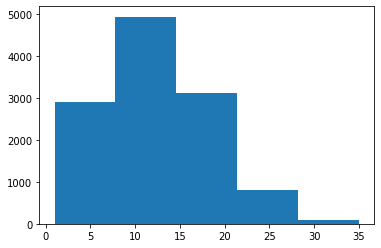

In [ ]:
# Histogram for all train, val, and test
sent_lengths = np.concatenate((train_sentence_lengths, val_sentence_lengths, test_sentence_lengths, add_test_sentence_lengths))
h= plt.hist(sent_lengths, bins=5)
print(h[1])
print(h[0])

[ 1  8 15 21 28 35]
[2119. 3540. 2051.  733.  101.]


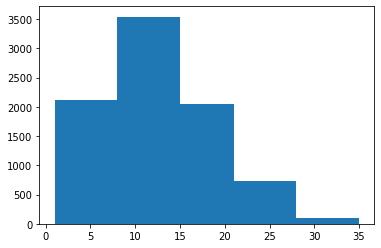

In [ ]:
# For training sentences only
h= plt.hist(train_sentence_lengths, bins=[1, 8, 15, 21, 28, 35])
print(h[1])
print(h[0])

[ 1  8 15 21 28 35]
[2908. 4943. 2860. 1030.  119.]


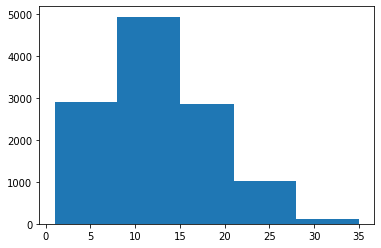

In [ ]:
# For all sentences
h= plt.hist(sent_lengths, bins=[1, 8, 15, 21, 28, 35])
print(h[1])
print(h[0])

## **Padding and Encoding**
After we get the sentence length distribution, we pad the sentences according to which bin they belong to (and we pad to the right-end of this bin). Then we encode each word into an integer index according to its row index in the embedding matrix

Note: integer_dict_val and integer_dict_test would convert the words in validation and test set according to the index in the concatenated matrix. We concatenate our training embedding matrix by the embeddings of additional words exclusively in val or val and test, and then finally followed by embeddings of words exclusively in test.

In [ ]:
def conv_sent_to_int(sentences, integer_dict, integer_dict_val, integer_dict_test): # convert each word in sentences to its index for embedding matrices
    int_sentences = []
    for sentence in sentences:
        int_sentence = []
        for word in sentence:
            if word in integer_dict:
                int_idx = integer_dict[word]
            elif word in integer_dict_val:
                int_idx = integer_dict_val[word]
            else:
                int_idx = integer_dict_test[word]
                
            int_sentence.append(int_idx)
        int_sentences.append(int_sentence)
        
    return int_sentences

In [ ]:
# conv training sentences to integer indexes of the embedding matrix
int_train_sent = conv_sent_to_int(sentences_train5, integer_dict_train, integer_dict_val, integer_dict_test)
int_val_sent = conv_sent_to_int(sentences_val5, integer_dict_train, integer_dict_val, integer_dict_test)
int_test_sent = conv_sent_to_int(sentences_test5, integer_dict_train, integer_dict_val, integer_dict_test)
int_add_test_sent = conv_sent_to_int(sentences_add_test5, integer_dict_train, integer_dict_val, integer_dict_test)

In [ ]:
# Quick check to ensure sentences are converted to integers correctly
err = 0
for sent in int_train_sent:
    for int_word in sent:
        word = list(integer_dict_train.keys())[int_word]
        err += np.sum(embedding_mat[int_word] - w2v[word])
print(err)

0.0


In [ ]:
err = 0
for sent in int_val_sent:
    for int_word in sent:
        if int_word >= embedding_mat.shape[0]:
            word = list(integer_dict_val.keys())[int_word-embedding_mat.shape[0]]
            err += np.sum(embedding_mat_val[int_word-embedding_mat.shape[0]] - w2v[word])
        else:
            word = list(integer_dict_train.keys())[int_word]
            err += np.sum(embedding_mat[int_word] - w2v[word])
print(err)

0.0


In [ ]:
err = 0
for sent in int_test_sent:
    for int_word in sent:
        if int_word >= embedding_mat.shape[0] + embedding_mat_val.shape[0]:
            word = list(integer_dict_test.keys())[int_word-embedding_mat.shape[0] - embedding_mat_val.shape[0]]
            err += np.sum(embedding_mat_test[int_word - embedding_mat.shape[0] - embedding_mat_val.shape[0]] - w2v[word])
        elif int_word >= embedding_mat.shape[0]:
            word = list(integer_dict_val.keys())[int_word-embedding_mat.shape[0]]
            err += np.sum(embedding_mat_val[int_word-embedding_mat.shape[0]] - w2v[word])
        else:
            word = list(integer_dict_train.keys())[int_word]
            err += np.sum(embedding_mat[int_word] - w2v[word])
print(err)

0.0


In [ ]:
err = 0
for sent in int_add_test_sent:
    for int_word in sent:
        if int_word >= embedding_mat.shape[0] + embedding_mat_val.shape[0]:
            word = list(integer_dict_test.keys())[int_word-embedding_mat.shape[0] - embedding_mat_val.shape[0]]
            err += np.sum(embedding_mat_test[int_word - embedding_mat.shape[0] - embedding_mat_val.shape[0]] - w2v[word])
        elif int_word >= embedding_mat.shape[0]:
            word = list(integer_dict_val.keys())[int_word-embedding_mat.shape[0]]
            err += np.sum(embedding_mat_val[int_word-embedding_mat.shape[0]] - w2v[word])
        else:
            word = list(integer_dict_train.keys())[int_word]
            err += np.sum(embedding_mat[int_word] - w2v[word])
print(err)

0.0


In [ ]:
def pad_int(int_sentences, labels, edges):
    # produce categories of padded int_sentences, along with their labels, and masks, and original lengths
    numcat = len(edges) - 1
    ori_len = []; labels_padded = []; int_padded = []; mask_padded = []
    for i in range(numcat):
        leng = []; out = []; cat = []; mask_collect = []
        for j in range(len(int_sentences)):
            seq_l = len(int_sentences[j])
            pad = np.zeros((edges[i+1]))
            mask = np.zeros((edges[i+1]))
            if seq_l > edges[i] and seq_l <= edges[i+1]:
                pad[0:seq_l] = int_sentences[j]
                mask[0:seq_l] = 1
                mask_collect.append(mask)
                leng.append(seq_l)
                cat.append(pad)
                out.append(labels[j])
                
        int_padded.append(np.array(cat).astype(np.int32))
        mask_padded.append(np.array(mask_collect).astype(np.int32))
        ori_len.append(leng)
        labels_padded.append(np.array(out).astype(np.int32))
    
    return ori_len, labels_padded, int_padded, mask_padded

In [ ]:
labels_train5=deepcopy(labels_train3)
labels_val5=deepcopy(labels_val3)
labels_test5=deepcopy(labels_test3)
labels_add_test5 = deepcopy(labels_add_test3)

In [ ]:
print(len(labels_add_test5), len(sentences_add_test5))

5 5


In [ ]:
edges = [0, 8, 15, 21, 28, 35]
len_train, labels_train_padded, int_train_padded, mask_train_padded = pad_int(int_train_sent, labels_train5, edges)
len_val, labels_val_padded, int_val_padded, mask_val_padded = pad_int(int_val_sent, labels_val5, edges)
len_test, labels_test_padded, int_test_padded, mask_test_padded = pad_int(int_test_sent, labels_test5, edges)
len_add_test, labels_add_test_padded, int_add_test_padded, mask_add_test_padded = pad_int(int_add_test_sent, labels_add_test5, edges)

## **Check after encoding each word to an integer index (of the embedding matri) and padding, that the sentences remains unchanged**

In [ ]:
sent = []
for word in int_add_test_padded[0][1]:
    if word >= embedding_mat.shape[0] + embedding_mat_val.shape[0]:
        sent.append(list(integer_dict_test.keys())[list(integer_dict_test.values()).index(word)]) 
    elif word >= embedding_mat.shape[0]:
        sent.append(list(integer_dict_val.keys())[list(integer_dict_val.values()).index(word)])
    else:
        sent.append(list(integer_dict_train.keys())[list(integer_dict_train.values()).index(word)])

print(sent, labels_add_test_padded[0][1], len(sent), mask_add_test_padded[0][1])

['Dark', 'Knight', 'Rises', 'was', 'perfect', 'sequel', 'UNK', 'masterpiece'] 4 8 [1 1 1 1 1 1 1 1]


In [ ]:
print(sentences_add_test5[1], len(sentences_add_test5[1]), labels_add_test5[1])

['Dark', 'Knight', 'Rises', 'was', 'perfect', 'sequel', 'UNK', 'masterpiece'] 8 4


In [ ]:
sent = []
for word in int_train_padded[3][0]:
    sent.append(list(integer_dict_train.keys())[list(integer_dict_train.values()).index(word)])
print(sent, labels_train_padded[3][0], len(sent), mask_train_padded[3][0])

['gorgeously', 'elaborate', 'continuation', 'The', 'Lord', 'Rings', 'trilogy', 'so', 'huge', 'column', 'words', 'can', 'not', 'adequately', 'describe', 'Peter', 'Jackson', 'expanded', 'vision', 'JRR', 'Tolkien', 'UNK', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock', 'Rock'] 4 28 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0]


In [ ]:
print(sentences_train5[0],len(sentences_train5[0]), labels_train5[0])

['Rock', 'destined', 'st', 'Century', 'new', 'Conan', 'he', 'going', 'make', 'splash', 'even', 'greater', 'than', 'Arnold', 'Schwarzenegger', 'UNK', 'Van', 'Damme', 'or', 'Steven', 'Segal'] 21 3


In [ ]:
print(sentences_val5[0],len(sentences_val5[0]), labels_val5[0])

['lovely', 'film', 'lovely', 'performances', 'by', 'Buy', 'UNK', 'Accorsi'] 8 3


In [ ]:
sent = []
for word in int_val_padded[1][0]:
    if word >= embedding_mat.shape[0]:
        sent.append(list(integer_dict_val.keys())[list(integer_dict_val.values()).index(word)])
    else:
        sent.append(list(integer_dict_train.keys())[list(integer_dict_train.values()).index(word)])
    
print(sent, labels_val_padded[1][0], len(sent), mask_val_padded[1][0])

['half', 'Submarine', 'flick', 'Half', 'Ghost', 'Story', 'All', 'one', 'criminally', 'neglected', 'film', 'Rock', 'Rock', 'Rock', 'Rock'] 2 15 [1 1 1 1 1 1 1 1 1 1 1 0 0 0 0]


In [ ]:
print(sentences_test5[0],len(sentences_test5[0]), labels_test5[0])

['effective', 'but', 'UNK', 'biopic'] 4 2


In [ ]:
sent = []
for word in int_test_padded[0][0]:
    if word >= embedding_mat.shape[0] + embedding_mat_val.shape[0]:
        sent.append(list(integer_dict_test.keys())[list(integer_dict_test.values()).index(word)]) 
    elif word >= embedding_mat.shape[0]:
        sent.append(list(integer_dict_val.keys())[list(integer_dict_val.values()).index(word)])
    else:
        sent.append(list(integer_dict_train.keys())[list(integer_dict_train.values()).index(word)])
    
print(sent, labels_test_padded[0][0], len(sent), mask_test_padded[0][0])

['effective', 'but', 'UNK', 'biopic', 'Rock', 'Rock', 'Rock', 'Rock'] 2 8 [1 1 1 1 0 0 0 0]


## **Normalize the embedding vectors**

In [ ]:
#Normalizing matrix

maxi=np.max(embedding_mat)
mini=np.min(embedding_mat)
embedding_mat1=2*(embedding_mat-mini)/(maxi-mini)-1
print(np.max(embedding_mat1))
print(np.min(embedding_mat1))

maxi=np.max(embedding_mat_val)
mini=np.min(embedding_mat_val)
embedding_mat_val1=2*(embedding_mat_val-mini)/(maxi-mini)-1
print(np.max(embedding_mat_val1))
print(np.min(embedding_mat_val1))

maxi=np.max(embedding_mat_test)
mini=np.min(embedding_mat_test)
embedding_mat_test1=2*(embedding_mat_test-mini)/(maxi-mini)-1
print(np.max(embedding_mat_test1))
print(np.min(embedding_mat_test1))


1.0
-1.0
1.0
-1.0
1.0
-1.0


## **Create Model**

In [ ]:
"""
Summarize data that we work with:
Non-padded groups, with pre-processing:
sentences_train5, labels_train5

Padded-groups, with pre-processing
len_train, labels_train_padded, int_train_padded, mask_train_padded

Same convention for val and test, simply replace train with val, test

Embedding matrix for training
embedding_mat

Embedding matrix for val and test:
concatenate embedding_mat (after training) with embedding_mat_val and embedding_mat_test
"""

In [ ]:
# To convert the integer labels to one-hot vectors
def one_hot_labels(labels):
    max_label = 4 # there are 5 labels, 0 to 4 exclusive
    m = labels.shape[0]
    oh_labels = np.zeros((m,max_label+1))
    oh_labels[np.arange(m),labels] = 1
    return labels, oh_labels

In [ ]:
# Model Skeleton for this task
class Model():
    def __init__(self, num_classes, nodes_per_layer, learning_rate, embedding_matrix, proj_length = 300, hlactivation = 'tanh', optimizer_name = "Adam", 
                 reg_coeff = 0, drop_prob = 0, train_embed = True, max_pool = True, min_pool = True, av_pool = True, isProject = True):
        
        """
        Inputs:
        num_classes = number of labels in the output
        nodes_per_layer = array of L values, where L is number of hidden layers in the MLP
        learning_rate = learning rate for the optimizer
        embedding_matrix = word embedding matrix to be used for the lookup layer
        hlactivation = activation of the MLP hidden layers. Default is tanh. Assume all layers have same activations
        optimizer_option = see below for choices, string argument
        reg_coeff = L2 regularization coefficient
        drop_prop = dropout probability
        train_embed = whether to train embedding matrix, default is true
        max, min, av_pool = Booleans to indicate which pooling to use
        """
        
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.embedding_matrix = np.array(embedding_matrix) # size is nVocab x embedding_length
        # need to declare as np array before passing to tf as initial value, otherwise become very slow

        nVocab, embedding_length = self.embedding_matrix.shape
        
        # Create input placeholders
        self.sent = tf.placeholder(tf.int32, shape = [None, None]) # input sentences fit here, shape is batch_size * padded_group_length
        self.labels = tf.placeholder(tf.int32, shape = [None, num_classes]) # one-hot encoding of the target labels
        self.isTrain = tf.placeholder(tf.bool, shape = None) # to activate/deactivate dropout
        self.mask = tf.placeholder(tf.int32, shape = [None, None]) # masks to indicate original sentence lengths, with ones on original words, and 0 on padded words
        self.n_dat = tf.placeholder(tf.int32, shape = None) # to know how many times to replicate the projection layer
        
        # Create embedding matrix as variable, to train. put self, so we can access the trained matrix
        self.embedder = tf.Variable(initial_value = self.embedding_matrix, name = 'Embedder', trainable = train_embed)
        proj_weights = tf.Variable(initial_value = np.random.randn(embedding_length, proj_length).astype(np.float32), name= 'proj_weights', trainable = True)
        
        # Also add placeholder for the 'predict' embedding matrix. Sufficient to use placeholder for this because
        # during predict (i.e. inference on validation and test set), we are NOT changing the embedding matrix
        # put as self so we can feed in
        self.embedder_infer = tf.placeholder(tf.float32, shape = [None, embedding_length])
        
        # Embedding_lookup layer
        embedded = tf.cond(tf.equal(self.isTrain,tf.constant(True)), lambda: tf.nn.embedding_lookup(self.embedder, self.sent),
                           lambda: tf.nn.embedding_lookup(self.embedder_infer, self.sent)) # i.e. if we are infering during validation
        # and test, we use the inference embedding matrix for lookup (i.e. the concatenated one)
        self.return_embedded = embedded

        # Project the embeddings to new vectors of length proj_length
        rep_proj_weights = tf.repeat(tf.expand_dims(proj_weights, axis = 0), [self.n_dat], axis = 0)

        if isProject:
            embedded = tf.linalg.matmul(embedded, rep_proj_weights)
            replicate_length = proj_length
        else:
            replicate_length = embedding_length
        # Pooling and masking operations
        # First, create 3D Mask
        mask_3D = tf.repeat(tf.expand_dims(self.mask, axis = 2), [replicate_length], axis = 2) # 2D masks are replicated along the embedding features (because discarding that word means disccarding its embedding vect)
        if max_pool:
            max_mask = tf.minimum(((2*tf.cast(mask_3D, tf.float32) - 1) * np.inf), embedded) # force entries where mask = 0, to be -inf
            pooled_max = tf.reduce_max(max_mask,axis = 1) # max over all words, i.e. along padded_length
        if min_pool:
            min_mask = tf.maximum(((1 - 2*tf.cast(mask_3D, tf.float32))* np.inf), embedded) # force entries where mask = 0, to be inf
            pooled_min = tf.reduce_min(min_mask, axis = 1)
        if av_pool:
            av_mask = tf.multiply(embedded, tf.cast(mask_3D, tf.float32)) # by element-wise multiplication, the entries where mask = 0 would be 0
            pooled_av = tf.reduce_mean(av_mask, axis = 1)

        # Concatenate pooling results
        if max_pool and min_pool and av_pool:
            print("All Pooling")
            embed_cat = tf.concat([pooled_av, pooled_max, pooled_min], axis = 1)
        elif max_pool and min_pool:
            print("Max and min Pooling")
            embed_cat = tf.concat([pooled_max, pooled_min], axis = 1)
        elif max_pool and av_pool:
            print("Max and Av Pooling")
            embed_cat = tf.concat([pooled_av, pooled_max], axis = 1)
        elif min_pool and av_pool:
            print("Min and av Pooling")
            embed_cat = tf.concat([pooled_av, pooled_min], axis = 1)
        elif max_pool:
            print("Max Pooling")
            embed_cat = pooled_max
        elif min_pool:
            print("Min Pooling")
            embed_cat = pooled_min
        elif av_pool:
            print("Av Pooling")
            embed_cat = pooled_av

        # Define MLP Layers
        out_lay = embed_cat
        for layer in range(0,len(nodes_per_layer)-1):
            out_node = nodes_per_layer[layer]
            if hlactivation == 'tanh':
                out_lay = tf.layers.dense(out_lay, out_node, activation = tf.nn.tanh, kernel_initializer =  tf.initializers.glorot_uniform,
                                        bias_initializer = tf.initializers.glorot_uniform)
                out_lay = tf.layers.dropout(out_lay, rate = drop_prob, training = self.isTrain)
            elif hlactivation == 'relu':
                out_lay = tf.layers.dense(out_lay, out_node, activation = tf.nn.relu, kernel_initializer =  tf.initializers.glorot_uniform,
                                        bias_initializer = tf.initializers.glorot_uniform)
                out_lay = tf.layers.dropout(out_lay, rate = drop_prob, training = self.isTrain)
            else:
                out_lay = tf.layers.dense(out_lay, out_node, activation = tf.nn.leaky_relu, kernel_initializer =  tf.initializers.glorot_uniform,
                                        bias_initializer = tf.initializers.glorot_uniform)
                out_lay = tf.layers.dropout(out_lay, rate = drop_prob, training = self.isTrain)

        # Define output layer
        out_lay = tf.layers.dense(out_lay, num_classes, kernel_initializer =  tf.initializers.glorot_uniform, bias_initializer = tf.initializers.glorot_uniform)
        
        
        
        # Define prediction operation (returns predictions in the form of non-one-hot labels)
        self.predictions = tf.reshape(tf.argmax(out_lay,1), [-1])
        
        # Define loss
        self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = self.labels, logits=out_lay))
        
        # Add L2 Regularization
        L2norms = [tf.nn.l2_loss(weights) for weights in tf.trainable_variables()]
        L2 = tf.reduce_sum(L2norms)
        self.loss_L2 = self.loss + reg_coeff * L2
        
        # Define training operation
        if optimizer_name == "Adam":
            optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
        elif optimizer_name == 'SGD':
            optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
        elif optimizer_name == 'RMSProp':
            optimizer = tf.train.RMSPropOptimizer(learning_rate = learning_rate)
        elif optimizer_name == 'Adagrad':
            optimizer = tf.train.AdagradOptimizer(learning_rate = learning_rate)

        self.train_op = optimizer.minimize(self.loss_L2)
        
        # Note: We don't define accuracy here. For evaluation on train and val after every epoch, return predictions and then
        # evaluate accuracy outside, using numpy
        

In [ ]:
# Predict function for the created model
def predict(model, int_sent_batch, labels_batch, mask_batch, embedding_mat, tfsession, batch_size = 1000):
    """
    This takes in ONE category of data of arbitrary sentence length, as well as the corresponding labels, and returns the count
    of correct results as well as the loss. Also takes in the CONCATENATED embedding matrix (with val and test words)
    
    Batch size here is how many samples to process at once. We want to be as large as possible technically, i.e. ideally to
    process whole batch in 1 go.
    
    Shapes:
    int_sent_batch = nData_in_cat x categ_len
    labels_batch = nData_in_cat (1-Dim)
    mask_batch = nData_in_cat x categ_len
    """
    # Same approach as train, i.e. divide whole chunk into batches
    nData, _ = int_sent_batch.shape
    
    # Need one-hot labels to evaluate loss
    _, labels_batch_oh = one_hot_labels(labels_batch)
    
    if batch_size >= nData:
        num_batch = 1
    elif nData % batch_size == 0:
        num_batch = (nData // batch_size)
    else:
        num_batch = (nData // batch_size) + 1
    
    count_correct = 0; loss_accum = 0; batch_total_length = 0
    for batch_ind in range(num_batch): # Iterate through each batch
        low_ind = (batch_ind) * batch_size
        high_ind = min(low_ind + batch_size, nData)
        
        # Extract the batch of data
        batch_in = int_sent_batch[low_ind:high_ind, :]
        batch_labels_oh = labels_batch_oh[low_ind:high_ind, :]
        batch_labels = labels_batch[low_ind:high_ind]
        batch_masks = mask_batch[low_ind:high_ind, :]
        
        # Extract the batch length (not always = batch size, in case nData < batch size)
        batch_length = batch_in.shape[0]
        
        # Create feed dictionary to predict
        feed_pred = {model.sent : batch_in, model.labels : batch_labels_oh, model.isTrain : False, model.mask : batch_masks, 
                     model.embedder_infer : embedding_mat, model.n_dat : batch_length}
        
        # Perform predictions to get average loss for this batch, and the predictions on this batch
        batch_pred, av_loss = tfsession.run([model.predictions, model.loss], feed_dict = feed_pred)
        
        # Sum up the loss and correct counts, because we want to average over ALL training data later
        loss_accum += av_loss * batch_length
        count_correct += np.sum(batch_pred == batch_labels)
        # count_correct += np.sum(np.abs(batch_pred - batch_labels) <= 1)
        batch_total_length += batch_length # sanity check, must be = nData
        
    
    
    return count_correct, loss_accum, nData
    

In [ ]:
# Training function for the created model
def train(model, int_train_padded, labels_train_padded, mask_train_padded, embedding_val, embedding_test, n_epochs, batch_size,
         int_val_padded, labels_val_padded, mask_val_padded, tfsession):
    """
    Train the model for n_epochs using the fed training data (already in integer form) and then predict on whole
    train and val after every epoch. Returns a list of acc and loss after every epoch.
    
    Also takes in the embeddings from val and test words (these are NOT in train, hence never updated, but are in w2v)
    to concatenate with the trained embeddings
    """
    # with tf.Session() as sess:
    embed_train = tfsession.run(model.embedder, feed_dict = None) # get initial training embedding matrix
        
    embedding_full = np.concatenate([embed_train, embedding_val, embedding_test], axis = 0)
    acc_train_per_epoch = []; loss_train_per_epoch = []; acc_val_per_epoch = []; loss_val_per_epoch = []
    # Start of each epoch.
    for epoch in range(n_epochs):
        # Shuffle the categories
#         c = list(zip(int_train_padded, labels_train_padded, mask_train_padded))
#         random.shuffle(c)
#         new_int_train, new_labels_train, new_mask_train = zip(*c) # new... are shuffled versions of the original, but shuffled in triplets accordingly
        c = list (zip(list(zip(int_train_padded, labels_train_padded)),mask_train_padded))
        random.shuffle(c)
        ab, new_mask_train = zip(*c)
        new_int_train, new_labels_train =zip(*ab)
        

        for categ in range(len(new_int_train)): # iterate through the categories
            group_int_inputs = new_int_train[categ]; group_labels = new_labels_train[categ]; group_masks = new_mask_train[categ]

            # Shuffle within category
            permute = np.random.permutation(group_int_inputs.shape[0])
            group_int_inputs = group_int_inputs[permute,:]
            group_labels = group_labels[permute]
            group_masks = group_masks[permute,:]

            # one-hot encode labels for training
            _, group_labels_oh = one_hot_labels(group_labels)

            # Take batches of data within categories, in case some categories contain too big of chunk
            nData,_ = group_int_inputs.shape

            if batch_size >= nData:
                num_batch = 1
            elif nData % batch_size == 0:
                num_batch = (nData // batch_size)
            else:
                num_batch = (nData // batch_size) + 1

            for batch_ind in range(num_batch): # Iterate through each batch
                low_ind = (batch_ind) * batch_size
                high_ind = min(low_ind + batch_size, nData)

                # Take in batch, all the data needed for TRAINING only.
                batch_in = group_int_inputs[low_ind:high_ind, :]
                batch_labels_oh = group_labels_oh[low_ind:high_ind, :]
                batch_masks = group_masks[low_ind:high_ind, :]
                batch_dat = batch_in.shape[0]

                # Create dictionary to feed
                feed_train = {model.sent : batch_in, model.labels : batch_labels_oh, model.isTrain : True, model.mask : batch_masks, 
                             model.embedder_infer : embedding_full, model.n_dat : batch_dat}

                # Train
                tfsession.run(model.train_op, feed_dict = feed_train)
                    
        # At the end of every epoch, update the embedding matrix from training, and re-concatenate with val and test
        embedding_train = tfsession.run(model.embedder, feed_dict = None)
        embedding_full = np.concatenate([embedding_train, embedding_val, embedding_test], axis = 0)
        
        # Then use this full embedding to do predictions on train and val. Complete the predict function above. It will take
        # the WHOLE training group from each category, and return the total loss as well as the total count of correct predict,
        # as well as the sample count (i.e. how many processed). Use these to compute sum over all categories, and take mean over
        # these to be our acc and loss respectively.
        whole_train_loss = 0; whole_train_count = 0; whole_val_loss = 0; whole_val_count = 0; train_samples = 0; val_samples = 0
        
        # For train
        for categ in range(len(new_int_train)): # iterate through the categories again, for inference
            group_int_inputs = new_int_train[categ]; group_labels = new_labels_train[categ]; group_masks = new_mask_train[categ]
            count_correct, loss_accum, batch_length = predict(model, group_int_inputs, group_labels, group_masks, embedding_full, tfsession, batch_size = 2000)
            whole_train_loss += loss_accum; whole_train_count += count_correct; train_samples += batch_length
            
        acc_train_per_epoch.append(whole_train_count / train_samples)
        loss_train_per_epoch.append(whole_train_loss / train_samples)
        
        # For val
        for categ in range(len(int_val_padded)): # iterate through the categories again, for inference
            group_int_inputs = int_val_padded[categ]; group_labels = labels_val_padded[categ]; group_masks = mask_val_padded[categ]
            count_correct, loss_accum, batch_length = predict(model, group_int_inputs, group_labels, group_masks, embedding_full, tfsession, batch_size = 2000)
            whole_val_loss += loss_accum; whole_val_count += count_correct; val_samples += batch_length
            
        acc_val_per_epoch.append(whole_val_count / val_samples)
        loss_val_per_epoch.append(whole_val_loss / val_samples)
        
        print(f"For epoch {epoch+1}, train acc and loss are {whole_train_count / train_samples} and {whole_train_loss / train_samples}")
        print(f"For epoch {epoch+1}, val acc and loss are {whole_val_count / val_samples} and {whole_val_loss / val_samples}")



    return acc_train_per_epoch, loss_train_per_epoch, acc_val_per_epoch, loss_val_per_epoch, embedding_full
        
        

In [ ]:
# Function to predict on dataset AFTER model has been trained
def predict_test(int_test_padded, labels_test_padded, mask_test_padded, embedding_mat, tfsession):
    whole_test_loss = 0; whole_test_count = 0; test_samples = 0
    for categ in range(len(int_test_padded)):
        group_int_inputs = int_test_padded[categ]; group_labels = labels_test_padded[categ]; group_masks = mask_test_padded[categ]
        count_correct, loss_accum, batch_length = predict(model, group_int_inputs, group_labels, group_masks, embedding_mat, tfsession, batch_size = 2000)
        whole_test_loss += loss_accum; whole_test_count += count_correct; test_samples += batch_length

    test_acc = whole_test_count / test_samples; test_loss = whole_test_loss / test_samples

    return test_acc, test_loss

In [ ]:
# Model Training Code Skeleton. We used this to explore hyperparameters by manually inputting the values we tried, and running this code
with tf.device('/device:GPU:0'):
  # Create Model
  embedding_train = embedding_mat; num_classes = 5; nodes_per_layer = [250, 125, num_classes]
  learning_rate = 0.001; reg_coeff = 2e-03; drop_prob = 0.1; embedding_val = embedding_mat_val
  embedding_test = embedding_mat_test; proj_length = 450

  tf.reset_default_graph()

  model = Model(num_classes, nodes_per_layer, learning_rate, embedding_train, reg_coeff= reg_coeff, drop_prob= drop_prob, proj_length = proj_length
  ,max_pool= False, min_pool= False, av_pool= True, optimizer_name= "Adam", train_embed= False, hlactivation = 'relu', isProject = False)

  # Input Data
  x_cat = int_train_padded; y_cat = labels_train_padded; mask_cat = mask_train_padded;
  x_val = int_val_padded; y_val = labels_val_padded; mask_val = mask_val_padded

  init = tf.initialize_all_variables()

  sess = tf.Session()
  sess.run(init)

  # Train
  acc_train, loss_train, acc_val, loss_val, embedding_full = train(model, x_cat, y_cat, mask_cat, embedding_val, embedding_test, 175, 1024, x_val, y_val, mask_val, sess)

  # Predict on test
  acc_test, loss_test = predict_test(int_test_padded, labels_test_padded, mask_test_padded, embedding_full, sess)

  argmax_val = np.argmax(acc_val)
  print(f"Max validation accuracy obtained at epoch {np.argmax(acc_val)+1} with value of {np.max(acc_val)}")
  print(f"Training accuracy at that epoch is {acc_train[argmax_val]}")
  print(f"Accuracy and loss on test using the final trained model is {acc_test} and {loss_test} respectively")

Av Pooling
For epoch 1, train acc and loss are 0.6125936329588015 and 1.5615642019983536
For epoch 1, val acc and loss are 0.6112624886466849 and 1.569592283705383
For epoch 2, train acc and loss are 0.7907303370786517 and 1.5394513485360235
For epoch 2, val acc and loss are 0.7983651226158038 and 1.5463853758319088
For epoch 3, train acc and loss are 0.767439138576779 and 1.5019375828935413
For epoch 3, val acc and loss are 0.773841961852861 and 1.5088932010718197
For epoch 4, train acc and loss are 0.8092228464419475 and 1.4494196102860268
For epoch 4, val acc and loss are 0.8192552225249773 and 1.4505763415528037
For epoch 5, train acc and loss are 0.8233848314606742 and 1.3891128782420123
For epoch 5, val acc and loss are 0.8256130790190735 and 1.3906553760644633
For epoch 6, train acc and loss are 0.8375468164794008 and 1.3402443308285559
For epoch 6, val acc and loss are 0.8374205267938238 and 1.3507794853127295
For epoch 7, train acc and loss are 0.8419943820224719 and 1.3097348

In [ ]:
# Grid Search Skeleton for the case where we do NOT train the embeddings, but use a projection matrix.
with tf.device('/device:GPU:0'):
  num_classes = 5
  reg_val = [2e-03, 2e-06]; nodes = [[10, 5, num_classes], [50, 25, num_classes], [250, 125, num_classes]]; drops = [0, 0.1]; plengths = [150, 300, 450]
  val_accs2 = np.zeros((2,3,2,3))
  for i in range(len(reg_val)):
    for j in range(len(nodes)):
      for k in range(len(drops)):
        for pl in range(len(plengths)):
          # Create Model
          embedding_train = embedding_mat; nodes_per_layer = nodes[j]
          learning_rate = 0.001; reg_coeff = reg_val[i]; drop_prob = drops[k]; embedding_val = embedding_mat_val
          embedding_test = embedding_mat_test; proj_length = plengths[pl]

          tf.reset_default_graph()

          model = Model(num_classes, nodes_per_layer, learning_rate, embedding_train, reg_coeff= reg_coeff, drop_prob= drop_prob, proj_length = proj_length
          ,max_pool= False, min_pool= True, av_pool= True, optimizer_name= "Adam", train_embed= False, hlactivation = 'relu', isProject = True)

          # Input Data
          x_cat = int_train_padded; y_cat = labels_train_padded; mask_cat = mask_train_padded;
          x_val = int_val_padded; y_val = labels_val_padded; mask_val = mask_val_padded

          init = tf.initialize_all_variables()

          sess = tf.Session()
          sess.run(init)

          # Train
          acc_train, loss_train, acc_val, loss_val, embedding_full = train(model, x_cat, y_cat, mask_cat, embedding_val, embedding_test, 10, 1024, x_val, y_val, mask_val, sess)

          # Predict on test
          acc_test, loss_test = predict_test(int_test_padded, labels_test_padded, mask_test_padded, embedding_full, sess)

          argmax_val = np.argmax(acc_val); best_val = np.max(acc_val)
          val_accs2[i,j,k,pl] = best_val
          print(f"Drop prob = {drop_prob}, Reg Coeff = {reg_coeff}, Nodes per Layer = {nodes_per_layer}, Projection Length = {proj_length}")
          print(f"Max validation accuracy obtained at epoch {np.argmax(acc_val)+1} with value of {np.max(acc_val)}")
          print(f"Training accuracy at that epoch is {acc_train[argmax_val]}")
          print(f"Accuracy and loss on test using the final trained model is {acc_test} and {loss_test} respectively")

Min and av Pooling
For epoch 1, train acc and loss are 0.12804307116104868 and 1.7102140562978576
For epoch 1, val acc and loss are 0.12897366030881016 and 1.7035370922218551
For epoch 2, train acc and loss are 0.12804307116104868 and 1.7044640784239056
For epoch 2, val acc and loss are 0.1262488646684832 and 1.6991276237555355
For epoch 3, train acc and loss are 0.12804307116104868 and 1.6995242531882244
For epoch 3, val acc and loss are 0.1262488646684832 and 1.6947457151560217
For epoch 4, train acc and loss are 0.12804307116104868 and 1.6948241316591308
For epoch 4, val acc and loss are 0.1262488646684832 and 1.6905140372214806
For epoch 5, train acc and loss are 0.12804307116104868 and 1.690474561426077
For epoch 5, val acc and loss are 0.1262488646684832 and 1.6864618731021448
For epoch 6, train acc and loss are 0.12816011235955055 and 1.6862127085805831
For epoch 6, val acc and loss are 0.1262488646684832 and 1.6825476003494402
For epoch 7, train acc and loss are 0.1283941947565

KeyboardInterrupt: ignored

In [ ]:
# Grid Search Skeleton Code, for the case where we do not use projection vector, and do NOT train the embeddings
with tf.device('/device:GPU:0'):
  reg_val = [2e-03, 2e-06]; nodes = [[10, 5, num_classes], [50, 25, num_classes], [250, 125, num_classes]]; drops = [0, 0.1]
  val_accs = np.zeros((2,3,2))
  for i in range(len(reg_val)):
    for j in range(len(nodes)):
      for k in range(len(drops)):
        # Create Model
        embedding_train = embedding_mat; num_classes = 5; nodes_per_layer = nodes[j]
        learning_rate = 0.001; reg_coeff = reg_val[i]; drop_prob = drops[k]; embedding_val = embedding_mat_val
        embedding_test = embedding_mat_test; proj_length = 300

        tf.reset_default_graph()

        model = Model(num_classes, nodes_per_layer, learning_rate, embedding_train, reg_coeff= reg_coeff, drop_prob= drop_prob, proj_length = proj_length
        ,max_pool= False, min_pool= False, av_pool= True, optimizer_name= "Adam", train_embed= False, hlactivation = 'relu', isProject = False)

        # Input Data
        x_cat = int_train_padded; y_cat = labels_train_padded; mask_cat = mask_train_padded;
        x_val = int_val_padded; y_val = labels_val_padded; mask_val = mask_val_padded

        init = tf.initialize_all_variables()

        sess = tf.Session()
        sess.run(init)

        # Train
        acc_train, loss_train, acc_val, loss_val, embedding_full = train(model, x_cat, y_cat, mask_cat, embedding_val, embedding_test, 500, 1024, x_val, y_val, mask_val, sess)

        # Predict on test
        acc_test, loss_test = predict_test(int_test_padded, labels_test_padded, mask_test_padded, embedding_full, sess)

        argmax_val = np.argmax(acc_val); best_val = np.max(acc_val)
        val_accs[i,j,k] = best_val
        print(f"Drop prob = {drop_prob}, Reg Coeff = {reg_coeff}, Nodes per Layer = {nodes_per_layer}")
        print(f"Max validation accuracy obtained at epoch {np.argmax(acc_val)+1} with value of {np.max(acc_val)}")
        print(f"Training accuracy at that epoch is {acc_train[argmax_val]}")
        print(f"Accuracy and loss on test using the final trained model is {acc_test} and {loss_test} respectively")

In [ ]:
# Grid Search code skeleton, for the case where we update the embeddings during training, and therefore do not use projections
with tf.device('/device:GPU:0'):
  reg_val = [2e-03, 2e-06]; nodes = [[8, num_classes], [32, num_classes], [128, num_classes]]; drops = [0, 0.1]
  val_accs3 = np.zeros((2,3,2))
  for i in range(len(reg_val)):
    for j in range(len(nodes)):
      for k in range(len(drops)):
        # Create Model
        embedding_train = embedding_mat; num_classes = 5; nodes_per_layer = nodes[j]
        learning_rate = 0.001; reg_coeff = reg_val[i]; drop_prob = drops[k]; embedding_val = embedding_mat_val
        embedding_test = embedding_mat_test; proj_length = 300

        tf.reset_default_graph()

        model = Model(num_classes, nodes_per_layer, learning_rate, embedding_train, reg_coeff= reg_coeff, drop_prob= drop_prob, proj_length = proj_length
        ,max_pool= False, min_pool= False, av_pool= True, optimizer_name= "Adam", train_embed= True, hlactivation = 'relu', isProject = False)

        # Input Data
        x_cat = int_train_padded; y_cat = labels_train_padded; mask_cat = mask_train_padded;
        x_val = int_val_padded; y_val = labels_val_padded; mask_val = mask_val_padded

        init = tf.initialize_all_variables()

        sess = tf.Session()
        sess.run(init)

        # Train
        acc_train, loss_train, acc_val, loss_val, embedding_full = train(model, x_cat, y_cat, mask_cat, embedding_val, embedding_test, 150, 1024, x_val, y_val, mask_val, sess)

        # Predict on test
        acc_test, loss_test = predict_test(int_test_padded, labels_test_padded, mask_test_padded, embedding_full, sess)

        argmax_val = np.argmax(acc_val); best_val = np.max(acc_val)
        val_accs3[i,j,k] = best_val
        print(f"Drop prob = {drop_prob}, Reg Coeff = {reg_coeff}, Nodes per Layer = {nodes_per_layer}")
        print(f"Max validation accuracy obtained at epoch {np.argmax(acc_val)+1} with value of {np.max(acc_val)}")
        print(f"Training accuracy at that epoch is {acc_train[argmax_val]}")
        print(f"Accuracy and loss on test using the final trained model is {acc_test} and {loss_test} respectively")

In [ ]:
# Print the result of the grid search, for the case where we do not train the word embeddings, and do not use projection matrix
res = np.argwhere(val_accs == np.max(val_accs))
print(res) # index of hyperparameters that achieves the highest maximum validation accuracy
print(val_accs) # maximum validation accuracies of every combination

In [ ]:
# Print the result of the grid search, for the case where we do not train the word embeddings, and use projection matrix
res2 = np.argwhere(val_accs2 == np.max(val_accs2))
print(res2) # index of hyperparameters that achieves the highest maximum validation accuracy
print(val_accs2) # maximum validation accuracies of every combination

[[0 0 1 1]
 [0 1 0 0]]


In [ ]:
# Print the result of the grid search, for the case where we do train the word embeddings, and do not use projection matrix
res3 = np.argwhere(val_accs3 == np.max(val_accs3))
print(res3) # index of hyperparameters that achieves the highest maximum validation accuracy
print(val_accs3) # maximum validation accuracies of every combination

In [ ]:
# Print the additional sentences (after they have been grouped due to padding lengths)
full_sentences = []
for group in int_add_test_padded:
  for sentence in group:
    sent = []
    for word in sentence:
      if word >= embedding_mat.shape[0] + embedding_mat_val.shape[0]:
        sent.append(list(integer_dict_test.keys())[list(integer_dict_test.values()).index(word)]) 
      elif word >= embedding_mat.shape[0]:
        sent.append(list(integer_dict_val.keys())[list(integer_dict_val.values()).index(word)])
      else:
        sent.append(list(integer_dict_train.keys())[list(integer_dict_train.values()).index(word)])
    full_sentences.append(sent)

for sentences in full_sentences:
  print(sentences)

['bitter', 'disappointment', 'awful', 'ending', 'UNK', 'brilliant', 'trilogy', 'Rock']
['Dark', 'Knight', 'Rises', 'was', 'perfect', 'sequel', 'UNK', 'masterpiece']
['lame', 'spy', 'spoof', 'no', 'real', 'laughs', 'or', 'surprises']
['not', 'The', 'Worst', 'Brit', 'Comedy', 'You', 'Will', 'See']
['christopher', 'Nolans', 'second', 'bundle', 'joy', 'The', 'Dark', 'Knight', 'exceeded', 'all', 'UNK', 'my', 'expectations', 'Rock', 'Rock']


In [ ]:
# Predict using the final trained model, and print the predicted ratings of the above additional sentences
add_predictions = []
for group_id in range(len(int_add_test_padded)):
  if len(int_add_test_padded[group_id]) > 0:
    feed_pred = {model.sent : int_add_test_padded[group_id],  model.isTrain : False, model.mask : mask_add_test_padded[group_id], 
                        model.embedder_infer : embedding_full, model.n_dat : len(int_add_test_padded[group_id])}
    preds = sess.run(model.predictions, feed_dict = feed_pred)
    add_predictions.append(preds)



print(add_predictions)

[array([0, 4, 0, 1]), array([4])]


In [ ]:
# Plot auxillary function for the trained model
def plot_acc_loss(acc_train, loss_train, acc_val, loss_val):
    fig,ax = plt.subplots(2,2, figsize = (15,10))
    ax[0][0].plot(range(len(acc_train)), acc_train)
    ax[0][0].set_title('Training accuracy')
    ax[0][0].set_xlabel('Epoch')
    ax[0][0].set_ylabel('Accuracy')
    ax[0][0].grid()
    
    ax[0][1].plot(range(len(loss_train)), loss_train)
    ax[0][1].set_title('Training Loss')
    ax[0][1].set_xlabel('Epoch')
    ax[0][1].set_ylabel('Accuracy')
    ax[0][1].grid()
    
    ax[1][0].plot(range(len(acc_val)), acc_val)
    ax[1][0].set_title('Validation accuracy')
    ax[1][0].set_xlabel('Epoch')
    ax[1][0].set_ylabel('Accuracy')
    ax[1][0].grid()
    
    ax[1][1].plot(range(len(loss_val)), loss_val)
    ax[1][1].set_title('Validation loss')
    ax[1][1].set_xlabel('Epoch')
    ax[1][1].set_ylabel('Accuracy')
    ax[1][1].grid()

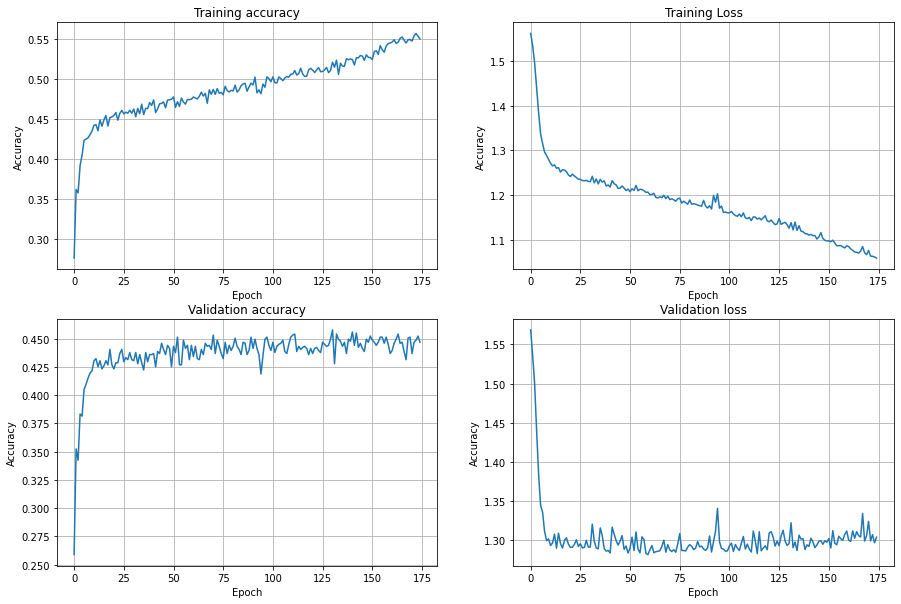

In [ ]:
# Template to print the training results of the trained model
plot_acc_loss(acc_train, loss_train, acc_val, loss_val)